<a href="https://colab.research.google.com/github/ammarSherif/CIT690E-Deep-Learning-Labs/blob/main/Lab%204%3A%20Batch%20Normalization%20and%20Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Batch Normalization and Dropout

CIT690E: Deep Learning <br>
Nile University<br>
Ammar Sherif<br>
Github Repo: [CIT690E-Deep-Learning-Labs](https://github.com/ammarSherif/CIT690E-Deep-Learning-Labs)

## Outline

During this lab, we cover the principles of batch normalization and show its impact; then, we do the same for dropout

In [1]:
# ==============================================================================
# Some imports that we are using in our lab
# ==============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [2]:
# ==============================================================================
# Identify the device at the beginning
# ==============================================================================
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## Dataset

We will use **FashionMNIST dataset**. It contains 70,000 samples of fashion images. Our objective is to build a model that is able to identify the item in an image. Below are some details:


*   60K training samples
*   10K testing samples
*   10 output classes, **classification**
*   Input image size: 28x28

In [3]:
# ==============================================================================
# Load the data and transform it
# ==============================================================================
train_data = FashionMNIST(root='./data',train=True,download=True,
                          transform=ToTensor())
val_data = FashionMNIST(root='./data',train=False,download=True,
                        transform=ToTensor())

In [29]:
# ==============================================================================
# Build a wraper to the dataset to normalize and flatten
# ==============================================================================
class FMNISTDataset(Dataset):
    def __init__(self, x, y, normalize = True):
        x = x.float()/255
        # ----------------------------------------------------------------------
        # We do not want it normalized to show the dropout effect
        # ----------------------------------------------------------------------
        if normalize:
            x = x/(1000)
        x = nn.Flatten()(x)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

# ==============================================================================
# Define a method that returns the data_loaders
# ==============================================================================
def get_data(dropout_exp = False):     
    train = FMNISTDataset(train_data.data, train_data.targets, not dropout_exp)     
    train_loader = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_data.data, val_data.targets, not dropout_exp)     
    val_loader = DataLoader(val, batch_size=len(val_data.data), shuffle=True)
    return train_loader, val_loader

## Normal FFNN
In this section, we write the code we will be using through our experiments:

In [5]:
# ==============================================================================
# Build a normal Feedforward Neural Network
# ==============================================================================
class FFNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.__input_to_hidden_layer = nn.Linear(784,1000)
        self.__hidden_layer_activation = nn.ReLU()
        self.__hidden_to_output_layer = nn.Linear(1000,10)
    def forward(self, x):
        # ------------------------------------------------------------------
        # Because we want  to know  the intermediate values,  we return both
        # value of the hidden layer after activation, and the final output. 
        # ------------------------------------------------------------------
        x = self.__input_to_hidden_layer(x)
        x1 = self.__hidden_layer_activation(x)
        y = self.__hidden_to_output_layer(x1)
        return y, x1

In [6]:
# ==============================================================================
# Define a method to perform one single batch training
# ==============================================================================
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)[0]
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()
# ==============================================================================
# Define the accuracy procedure
# ==============================================================================
def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)[0]
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [7]:
# ==============================================================================
# Define the loss function and other parameters
# ==============================================================================
loss_fn = nn.CrossEntropyLoss()
model_ffnn = FFNN().to(device)
optimizer_ffnn = Adam(model_ffnn.parameters(), lr=1e-3)

In [8]:
# ==============================================================================
# define the validation loss value
# ==============================================================================
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)[0]
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

### Training and Results

In [9]:
# ==============================================================================
# Define our training procedure
# ==============================================================================
def train_procedure(model,optimizer,trn_dl,val_dl, max_epochs):
  train_losses, train_accuracies = [], []
  val_losses, val_accuracies = [], []
  for epoch in range(max_epochs):
      train_epoch_losses, train_epoch_accuracies = [], []
      for ix, batch in enumerate(iter(trn_dl)):
          x, y = batch
          batch_loss = train_batch(x, y, model, optimizer, loss_fn)
          train_epoch_losses.append(batch_loss)        
      train_epoch_loss = np.array(train_epoch_losses).mean()

      for ix, batch in enumerate(iter(trn_dl)):
          x, y = batch
          is_correct = accuracy(x, y, model)
          train_epoch_accuracies.extend(is_correct)
      train_epoch_accuracy = np.mean(train_epoch_accuracies)

      for ix, batch in enumerate(iter(val_dl)):
          x, y = batch
          val_is_correct = accuracy(x, y, model)
          validation_loss = val_loss(x, y, model)
      val_epoch_accuracy = np.mean(val_is_correct)

      print(f"Epoch [{epoch+1:2}]: Train Acc: {train_epoch_accuracy:.2%}, \
          \tVal Acc: {val_epoch_accuracy:.2%}")
      train_losses.append(train_epoch_loss)
      train_accuracies.append(train_epoch_accuracy)
      val_losses.append(validation_loss)
      val_accuracies.append(val_epoch_accuracy)

  return train_losses, train_accuracies, val_losses, val_accuracies

In [10]:
# ==============================================================================
# Get the training data loader
# ==============================================================================
max_epochs = 40
dropout_exp = False
train_loader, val_loader = get_data(dropout_exp)
# ==============================================================================
# Train
# ==============================================================================
train_losses, train_accuracies, val_losses, val_accuracies = \
    train_procedure(model_ffnn, optimizer_ffnn, train_loader, val_loader, 
                    max_epochs)

Epoch [ 1]: Train Acc: 73.65%,           	Val Acc: 73.34%
Epoch [ 2]: Train Acc: 77.92%,           	Val Acc: 77.24%
Epoch [ 3]: Train Acc: 80.08%,           	Val Acc: 78.90%
Epoch [ 4]: Train Acc: 81.34%,           	Val Acc: 80.09%
Epoch [ 5]: Train Acc: 81.99%,           	Val Acc: 80.74%
Epoch [ 6]: Train Acc: 83.25%,           	Val Acc: 81.85%
Epoch [ 7]: Train Acc: 83.61%,           	Val Acc: 82.18%
Epoch [ 8]: Train Acc: 84.52%,           	Val Acc: 83.10%
Epoch [ 9]: Train Acc: 84.07%,           	Val Acc: 82.71%
Epoch [10]: Train Acc: 85.02%,           	Val Acc: 83.63%
Epoch [11]: Train Acc: 84.76%,           	Val Acc: 83.16%
Epoch [12]: Train Acc: 85.54%,           	Val Acc: 83.96%
Epoch [13]: Train Acc: 85.58%,           	Val Acc: 83.69%
Epoch [14]: Train Acc: 85.67%,           	Val Acc: 84.26%
Epoch [15]: Train Acc: 85.94%,           	Val Acc: 84.01%
Epoch [16]: Train Acc: 86.18%,           	Val Acc: 84.61%
Epoch [17]: Train Acc: 86.46%,           	Val Acc: 84.76%
Epoch [18]: Tr

In [11]:
# ==============================================================================
# Plot the model loss and accuracy
# ==============================================================================
def plot_loss_acc(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = np.arange(max_epochs)+1
    plt.subplot(211)
    plt.plot(epochs, train_losses, 'bo', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    #plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.title('Training and validation loss with very small input values')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid('off')
    plt.show()
    plt.subplot(212)
    plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
    #plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.title('Training and validation accuracy with very small input values')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    #plt.ylim(0.8,1)
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca()\
                              .get_yticks()]) 
    plt.legend()
    plt.grid('off')
    plt.show()

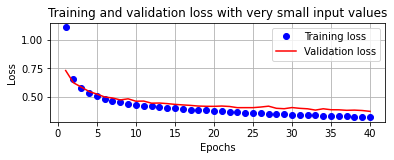

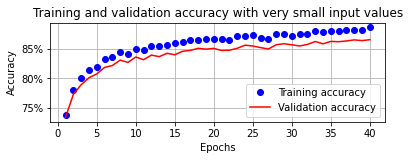

In [12]:
plot_loss_acc(train_losses, val_losses, train_accuracies, val_accuracies)

In [13]:
# ==============================================================================
# Show hidden layer node values
# ==============================================================================
def show_hidden_dist(model, data_loader, title="Hidden Value Distribution"):
    x, _ = next(iter(data_loader))
    # --------------------------------------------------------------------------
    # Get the distribution of the values in the hidden layer
    # --------------------------------------------------------------------------
    plt.hist(model(x)[1].cpu().detach().numpy().flatten())
    plt.title("Hidden Value Distribution")

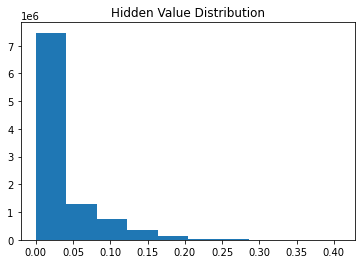

In [14]:
show_hidden_dist(model_ffnn, val_loader)

In [15]:
def plot_weight_dist(model):
  for ix, par in enumerate(model.parameters()):
      if(ix==0):
          plt.hist(par.cpu().detach().numpy().flatten())
          #plt.xlim(-2,2)
          plt.title('Distribution of weights [input to hidden]')
          plt.show()
      elif(ix ==1):
          plt.hist(par.cpu().detach().numpy().flatten())
          #plt.xlim(-2,2)
          plt.title('Distribution of biases of hidden layer')
          plt.show()
      elif(ix==2):
          plt.hist(par.cpu().detach().numpy().flatten())
          #plt.xlim(-2,2)
          plt.title('Distribution of weights [hidden to output]')
          plt.show()
      elif(ix ==3):
          plt.hist(par.cpu().detach().numpy().flatten())
          #plt.xlim(-2,2)
          plt.title('Distribution of biases of output layer')
          plt.show()  


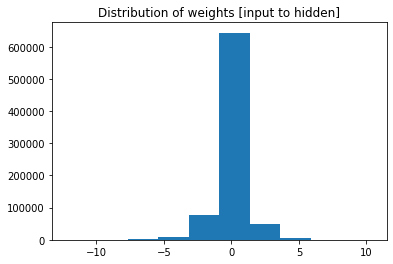

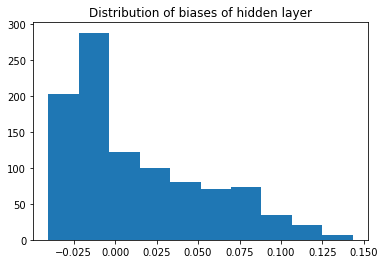

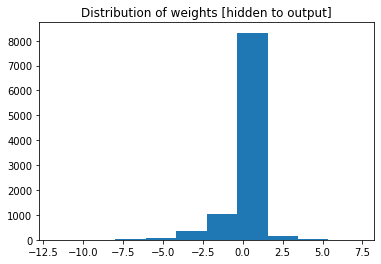

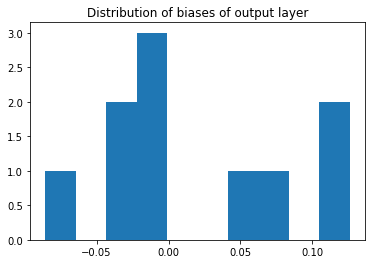

In [16]:
plot_weight_dist(model_ffnn)

## Batch Normalization

**Batch normalization** simply normalizes the *inputs to each layer* within the network according to the current batch while training. Below we build two models with and without the BN layers.

In [17]:
# ==============================================================================
# Build a normal Feedforward Neural Network with BN layer
# ==============================================================================
class BN_FFNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.__input_to_hidden_layer = nn.Linear(784,1000)
        self.__hidden_layer_activation = nn.ReLU()
        self.__batch_norm = nn.BatchNorm1d(1000)
        self.__hidden_to_output_layer = nn.Linear(1000,10)
    def forward(self, x):
        # ------------------------------------------------------------------
        # Because we want  to know  the intermediate values,  we return both
        # value of the hidden layer after activation, and the final output. 
        # ------------------------------------------------------------------
        x = self.__input_to_hidden_layer(x)
        # ------------------------------------------------------------------
        # We normalize the value before using the Relu Activation
        # ------------------------------------------------------------------
        x = self.__batch_norm(x)
        x1 = self.__hidden_layer_activation(x)
        y = self.__hidden_to_output_layer(x1)
        return y, x1

In [18]:
# ==============================================================================
# Define the model and its optimizer
# ==============================================================================
model_bn = BN_FFNN().to(device)
optimizer_bn = Adam(model_bn.parameters(), lr=1e-3)

In [19]:
# ==============================================================================
# Train
# ==============================================================================
train_losses_bn, train_accuracies_bn, val_losses_bn, val_accuracies_bn = \
    train_procedure(model_bn, optimizer_bn, train_loader, val_loader, 
                    max_epochs)

Epoch [ 1]: Train Acc: 87.16%,           	Val Acc: 86.11%
Epoch [ 2]: Train Acc: 83.02%,           	Val Acc: 81.27%
Epoch [ 3]: Train Acc: 85.82%,           	Val Acc: 84.06%
Epoch [ 4]: Train Acc: 85.89%,           	Val Acc: 84.23%
Epoch [ 5]: Train Acc: 86.02%,           	Val Acc: 84.41%
Epoch [ 6]: Train Acc: 87.77%,           	Val Acc: 86.20%
Epoch [ 7]: Train Acc: 87.50%,           	Val Acc: 86.03%
Epoch [ 8]: Train Acc: 87.15%,           	Val Acc: 85.44%
Epoch [ 9]: Train Acc: 86.06%,           	Val Acc: 84.29%
Epoch [10]: Train Acc: 89.05%,           	Val Acc: 87.00%
Epoch [11]: Train Acc: 89.18%,           	Val Acc: 87.11%
Epoch [12]: Train Acc: 88.97%,           	Val Acc: 87.09%
Epoch [13]: Train Acc: 88.45%,           	Val Acc: 86.51%
Epoch [14]: Train Acc: 86.71%,           	Val Acc: 85.02%
Epoch [15]: Train Acc: 88.66%,           	Val Acc: 86.43%
Epoch [16]: Train Acc: 88.64%,           	Val Acc: 86.53%
Epoch [17]: Train Acc: 89.12%,           	Val Acc: 87.06%
Epoch [18]: Tr

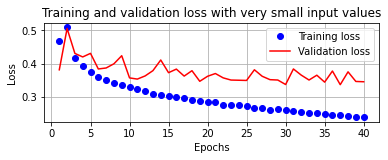

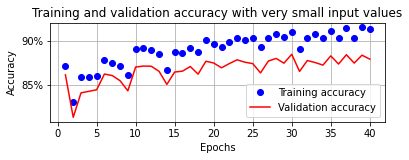

In [20]:
plot_loss_acc(train_losses_bn, val_losses_bn, train_accuracies_bn, 
              val_accuracies_bn)

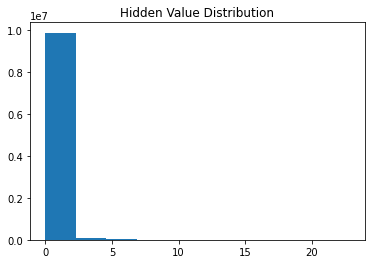

In [21]:
show_hidden_dist(model_bn, val_loader)

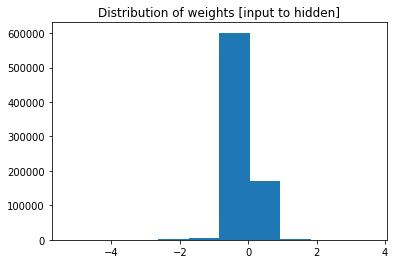

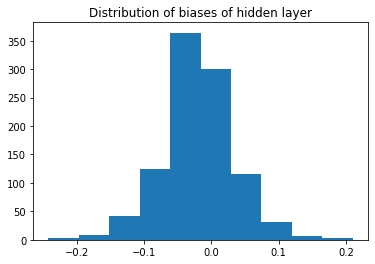

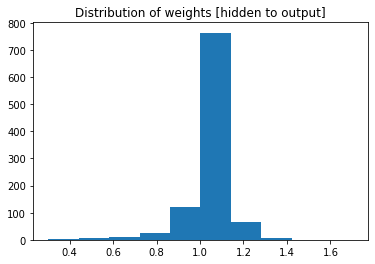

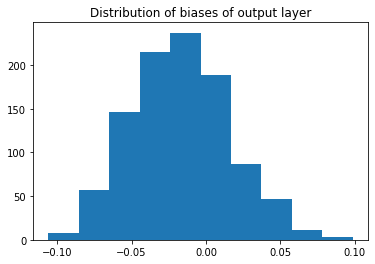

In [22]:
plot_weight_dist(model_bn)

## Dropout

Dropout is simply a technique that shuts down some of the neurons while training producing a regularization effect. We cover the problem first, and provide some intuition to think about it.

### Overfitting

Let's talk about the problem itself, first, which is overfitting. The point of overfitting is that we have **more capacity in our model**, capability to learn and complexity, so the model **starts learning unuseful, or even harmful, stuff** producing bad decision. Think of your camera; the more complexity it has, the more it is able to see the details. Thus, if you train on poor camera, you will focus on the general structure, which mostly is good. 

Eventually, that extra capacity comes from the model parameters and non-linearity. Therefore, we can reduce that effect by simply **shutting down some of these capacity during training**, which is exactly what dropout does.

### Intuition



Therefore, you might be asking *how shutting down some neurons could be any hepful to model training*. To build your intuition, think of a development team. This team has many members, but they learn to do a simple task. In such case, each one will highly specialize in one thing. Because there are many members, we are mostly sure that **many will learn useless stuff**. On the other hand, what will happen if every day **some of the members are absent?** In such case, the team members will learn to cover each other producing better outcome.

### Normal Model

We will train again the normal model, to compare the restults with the dropout one.

In [30]:
# ==============================================================================
# Get the training data loader
# ==============================================================================
max_epochs = 40
dropout_exp = True
train_loader, val_loader = get_data(dropout_exp)
# ==============================================================================
# Train
# ==============================================================================
train_losses, train_accuracies, val_losses, val_accuracies = \
    train_procedure(model_ffnn, optimizer_ffnn, train_loader, val_loader, 
                    max_epochs)

Epoch [ 1]: Train Acc: 94.01%,           	Val Acc: 87.76%
Epoch [ 2]: Train Acc: 94.96%,           	Val Acc: 88.25%
Epoch [ 3]: Train Acc: 95.43%,           	Val Acc: 88.28%
Epoch [ 4]: Train Acc: 95.37%,           	Val Acc: 88.00%
Epoch [ 5]: Train Acc: 95.50%,           	Val Acc: 88.02%
Epoch [ 6]: Train Acc: 92.55%,           	Val Acc: 85.67%
Epoch [ 7]: Train Acc: 94.28%,           	Val Acc: 87.28%
Epoch [ 8]: Train Acc: 94.31%,           	Val Acc: 87.15%
Epoch [ 9]: Train Acc: 93.39%,           	Val Acc: 86.40%
Epoch [10]: Train Acc: 93.83%,           	Val Acc: 87.03%
Epoch [11]: Train Acc: 94.93%,           	Val Acc: 87.86%
Epoch [12]: Train Acc: 94.89%,           	Val Acc: 87.71%
Epoch [13]: Train Acc: 94.55%,           	Val Acc: 87.31%
Epoch [14]: Train Acc: 95.09%,           	Val Acc: 87.38%
Epoch [15]: Train Acc: 94.88%,           	Val Acc: 87.38%
Epoch [16]: Train Acc: 95.43%,           	Val Acc: 87.72%
Epoch [17]: Train Acc: 95.15%,           	Val Acc: 87.47%
Epoch [18]: Tr

### Model

In [31]:
# ==============================================================================
# Build a normal Feedforward Neural Network with Dropout layers
# ==============================================================================
class Dropout_FFNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.__input_to_hidden_layer = nn.Linear(784,1000)
        self.__dropout = nn.Dropout(0.5)
        self.__hidden_layer_activation = nn.ReLU()
        self.__hidden_to_output_layer = nn.Linear(1000,10)
    def forward(self, x):
        # ------------------------------------------------------------------
        # Apply the first dropout
        # ------------------------------------------------------------------
        x = self.__dropout(x)
        x = self.__input_to_hidden_layer(x)
        # ------------------------------------------------------------------
        # Use the Activation function
        # ------------------------------------------------------------------
        x1 = self.__hidden_layer_activation(x)
        x1 = self.__dropout(x1)
        y = self.__hidden_to_output_layer(x1)
        return y, x1

In [32]:
# ==============================================================================
# Define the model and its optimizer
# ==============================================================================
model_drop = Dropout_FFNN().to(device)
optimizer_drop = Adam(model_drop.parameters(), lr=1e-3)

In [33]:
# ==============================================================================
# Train
# ==============================================================================
train_losses_drop, train_acc_drop, val_losses_drop, val_acc_drop = \
    train_procedure(model_drop, optimizer_drop, train_loader, val_loader, 
                    max_epochs)

Epoch [ 1]: Train Acc: 79.86%,           	Val Acc: 78.59%
Epoch [ 2]: Train Acc: 86.91%,           	Val Acc: 85.38%
Epoch [ 3]: Train Acc: 88.54%,           	Val Acc: 86.45%
Epoch [ 4]: Train Acc: 89.59%,           	Val Acc: 87.70%
Epoch [ 5]: Train Acc: 89.39%,           	Val Acc: 87.19%
Epoch [ 6]: Train Acc: 90.88%,           	Val Acc: 88.13%
Epoch [ 7]: Train Acc: 91.29%,           	Val Acc: 88.60%
Epoch [ 8]: Train Acc: 91.76%,           	Val Acc: 88.59%
Epoch [ 9]: Train Acc: 90.76%,           	Val Acc: 87.36%
Epoch [10]: Train Acc: 91.66%,           	Val Acc: 88.06%
Epoch [11]: Train Acc: 92.64%,           	Val Acc: 88.68%
Epoch [12]: Train Acc: 92.91%,           	Val Acc: 88.90%
Epoch [13]: Train Acc: 93.55%,           	Val Acc: 89.22%
Epoch [14]: Train Acc: 92.52%,           	Val Acc: 88.84%
Epoch [15]: Train Acc: 93.69%,           	Val Acc: 89.21%
Epoch [16]: Train Acc: 93.70%,           	Val Acc: 88.72%
Epoch [17]: Train Acc: 94.22%,           	Val Acc: 89.64%
Epoch [18]: Tr

### Results

#### Normal

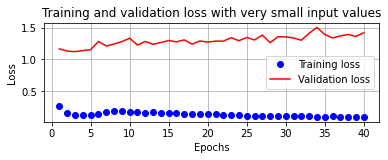

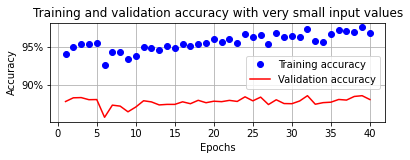

In [34]:
plot_loss_acc(train_losses, val_losses, train_accuracies, val_accuracies)

#### Dropout

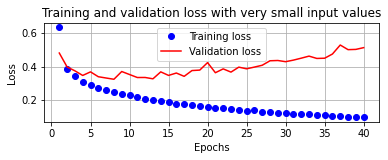

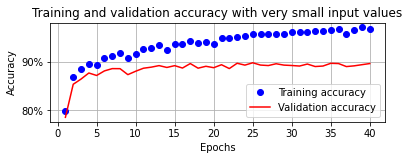

In [35]:
plot_loss_acc(train_losses_drop, val_losses_drop, train_acc_drop, 
              val_acc_drop)

### Comments

As we can see, the gap between the training and validation is much lower when using dropout than without it. This should clarify the effect of our dropout layer.